Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

# References
* [multiprocessing basics](https://pymotw.com/2/multiprocessing/basics.html)
* [Python 201: A multiprocessing tutorial](https://www.blog.pythonlibrary.org/2016/08/02/python-201-a-multiprocessing-tutorial/)
* [Multithread - Konrad Hinsen](http://calcul.math.cnrs.fr/Documents/Ecoles/2013/python/Multiprocessing.pdf)
* [Parallel Data Analysis in Python | SciPy 2017 Tutorial | Matthew Rocklin, Ben Zaitlen & Aron Ahmadia](https://youtu.be/a8gpcnmggiU)

## Simple map reduce example

In [54]:
from time import sleep
def f(x):
    sleep(1)
    return x*x
L = list(range(8))
L

[0, 1, 2, 3, 4, 5, 6, 7]

In [66]:
%time sum([f(x) for x in L])

CPU times: user 40.7 ms, sys: 40 ms, total: 80.7 ms
Wall time: 8.03 s


140

In [67]:
%time sum(map(f,L))

CPU times: user 41.7 ms, sys: 67.2 ms, total: 109 ms
Wall time: 8.04 s


140

# Multiprocessing

- The multiprocessing allows the programmer to fully leverage multiple processors. 
- It runs on both Unix and Windows.
- The `Pool` object parallelizes the execution of a function across multiple input values.
- The if `__name__ == '__main__'` part is necessary.

In [69]:
%%time
from multiprocessing import Pool

if __name__ == '__main__': # Executed only on main process.
    with Pool(4) as p:
        result = sum(p.map(f, L))
result

CPU times: user 20.6 ms, sys: 27.6 ms, total: 48.2 ms
Wall time: 2.1 s


In [71]:
def g(x, y): return x+y  # Function executed on worker processes.

if __name__ == '__main__': # Executed only on main process.
    with Pool(4) as p:
        result = p.starmap(g,((x,y) for x,y in zip(L,L)))
result

[0, 2, 4, 6, 8, 10, 12, 14]

## Asynchronous Apply

In [73]:
%%time
from multiprocessing import Pool
import numpy

if __name__ == '__main__':
    pool = Pool()
    results = [pool.apply_async(f, (x,))
               for x in L]
    roots = [r.get() for r in results]
    print(roots)

[0, 1, 4, 9, 16, 25, 36, 49]
CPU times: user 19.2 ms, sys: 35 ms, total: 54.2 ms
Wall time: 1.04 s


Use for:
- `pool.apply_async` returns a proxy object immediately
- `proxy.get()` waits for task completion and returns the result
- launching different tasks in parallel
- launching tasks with more than one argument 
- better control of task distribution

# The Process class

In multiprocessing, processes are spawned by creating a Process object and then calling its start() method. 

In [9]:
from multiprocessing import Process

def f(name):
    print('hello', name)

if __name__ == '__main__':
    p = Process(target=f, args=('bob',))
    p.start()
    p.join()

hello bob



# Exchanging objects between processes

## Queues

In [10]:
from multiprocessing import Process, Queue

def f(q):
    q.put([42, None, 'hello'])

if __name__ == '__main__':
    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    print(q.get())    # prints "[42, None, 'hello']"
    p.join()


[42, None, 'hello']


## Pipes
Pipe() returns two connection objects. Each connection object has send() and recv() methods

In [11]:
from multiprocessing import Process, Pipe

def f(conn):
    conn.send([42, None, 'hello'])
    conn.close()

if __name__ == '__main__':
    parent_conn, child_conn = Pipe()
    p = Process(target=f, args=(child_conn,))
    p.start()
    print(parent_conn.recv())   # prints "[42, None, 'hello']"
    p.join()

[42, None, 'hello']


# Synchronization between processes

In [12]:
from multiprocessing import Process, Lock

def f(l, i):
    l.acquire()
    try:
        print( i, end = ' ')
    finally:
        l.release()

if __name__ == '__main__':
    lock = Lock()

    for num in range(10):
        Process(target=f, args=(lock, num)).start()

0 1 2 3 4 5 6 7 8 9 

In [13]:
def f( i):
    print( i, end = ' ')

if __name__ == '__main__':
    for num in range(10):
        Process(target=f, args=(num,)).start()

0 1 2 3 4 5 6 7 8 9 

# Shared memory between processes

In [4]:
from multiprocessing import Process, Value, Array

def f(n, a):
    n.value = 3.1415927
    for i in range(len(a)):
        a[i] = -a[i]  # change sign in a list

if __name__ == '__main__':
    num = Value('d', 0.0)
    arr = Array('i', range(10))

    p = Process(target=f, args=(num, arr))
    p.start()
    p.join()

    print(num.value)
    print(arr[:])

3.1415927
[0, -1, -2, -3, -4, -5, -6, -7, -8, -9]


- Shared memory eliminates the serialization overhead.
- Don’t modify shared memory contents in the slave processes. 
- Use shared memory only to transfer data from the master to the slaves!

## Pi computation example

In [1]:
import time
import random
from multiprocessing import Pool, cpu_count

def compute_pi(n):
    count = 0
    for i in range(n):
        x=random.random()
        y=random.random()
        if x*x + y*y <= 1: count+=1
    return count

if __name__=='__main__':
    
    for np in range(1,5):
        elapsed_time = time.time()
        assert ( np <= cpu_count())
        
        n = 1000000
        part_count=[n//np for i in range(np)]
        pool = Pool(processes=np)   
        count=pool.map(compute_pi, part_count)
        print ("Number of cores {0}, Estimated value of Pi : {1:.8f}"
       " time : {2:.8f}".format(np, 4*sum(count)/n,time.time()-elapsed_time))

Number of cores 1, Estimated value of Pi : 3.14157200 time : 0.36684513
Number of cores 2, Estimated value of Pi : 3.13965200 time : 0.17848516
Number of cores 3, Estimated value of Pi : 3.14366400 time : 0.13128805
Number of cores 4, Estimated value of Pi : 3.14054400 time : 0.10560989


## Name processes, start and join.

In [4]:
import os
 
from multiprocessing import Process, current_process
 
def doubler(number):
    """
    A doubling function that can be used by a process
    """
    result = number * 2
    proc_name = current_process().name
    print('{0:2d} doubled to {1:2d} by: {2}'.format(
        number, result, proc_name))
 
if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []
    
    for i, number in enumerate(numbers):
        proc = Process(target=doubler, name='Proc-'+str(i),
                       args=(number,))
        procs.append(proc)
        proc.start() # Execute task on process
 
    for proc in procs:
        proc.join() # Get the result

 5 doubled to 10 by: Proc-0
10 doubled to 20 by: Proc-1
15 doubled to 30 by: Proc-2
20 doubled to 40 by: Proc-3
25 doubled to 50 by: Proc-4


# Futures

The concurrent.futures module provides a high-level interface for asynchronously executing callables.

The asynchronous execution can be performed with threads, using ThreadPoolExecutor, or separate processes, using ProcessPoolExecutor. Both implement the same interface, which is defined by the abstract Executor class.

In [30]:
%%time
import time
results = []
for i in range(8):
    time.sleep(1)
    results.append(i + 1)

CPU times: user 16.9 ms, sys: 31.6 ms, total: 48.5 ms
Wall time: 8.02 s


In [31]:
%%time
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor()
def slowinc(x):
    time.sleep(1)
    return x + 1
results = list(e.map(slowinc, range(8)))

CPU times: user 14.4 ms, sys: 27.6 ms, total: 42 ms
Wall time: 1.03 s


Today most library designers are coordinating around the concurrent.futures interface, so it's wise to move over.

* Used snakeviz to profile code
* Used concurrent.futures.ProcessPoolExecutor for simple parallelism 
* Gained some speed boost (but not as much as expected)
* Lost ability to diagnose performance within parallel code
* Describing each task as a function call helps use tools like map for parallelism
* Making your tasks fast is often at least as important as parallelizing your tasks.

# Asynchronous Future
While many parallel applications can be described as maps, some can be more complex. In this section we look at the asynchronous Future interface, which provides a simple API for ad-hoc parallelism. This is useful for when your computations don't fit a regular pattern.


### Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [32]:
from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

In [33]:
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
future = e.submit(slowadd, 1, 2)
future

<Future at 0x10759c3c8 state=running>

In [34]:
future.result()

3

Submit many tasks all at once and they be will executed in parallel.

In [35]:
%%time
results = [slowadd(i, i, delay=1) for i in range(10)]

CPU times: user 20.9 ms, sys: 42.8 ms, total: 63.6 ms
Wall time: 10 s


In [36]:
%%time
futures = [e.submit(slowadd, 1, 1, delay=1) for i in range(10)]
results = [f.result() for f in futures]

CPU times: user 7.26 ms, sys: 14.8 ms, total: 22.1 ms
Wall time: 3.01 s


*  Submit fires off a single function call in the background, returning a future.  
*  When you combine submit with a single for loop we recover the functionality of map.  
*  To collect your results, replace each of futures, `f`, with a call to `f.result()`
*  Combine submit with multiple for loops and other general programming to get something more general than map.
*  Sometimes, it did not speed up the code very much
*  Threads and processes show some performance differences
*  Use threads carefully, you can break your Python session.

# Joblib

[Joblib](http://pythonhosted.org/joblib/) provides a simple helper class to write parallel for loops using multiprocessing. 

In [56]:
%%time
from joblib import Parallel, delayed
result = Parallel(n_jobs=2)(delayed(f)(x) for x in L)
sum(result)

CPU times: user 56.1 ms, sys: 57.3 ms, total: 113 ms
Wall time: 4.11 s


# Dask

In [57]:
from dask import delayed
tasks = [delayed(f)(x) for x in L]
result = delayed(sum)(tasks)

In [59]:
%time result.compute()

CPU times: user 7.5 ms, sys: 6.66 ms, total: 14.2 ms
Wall time: 1.01 s


140

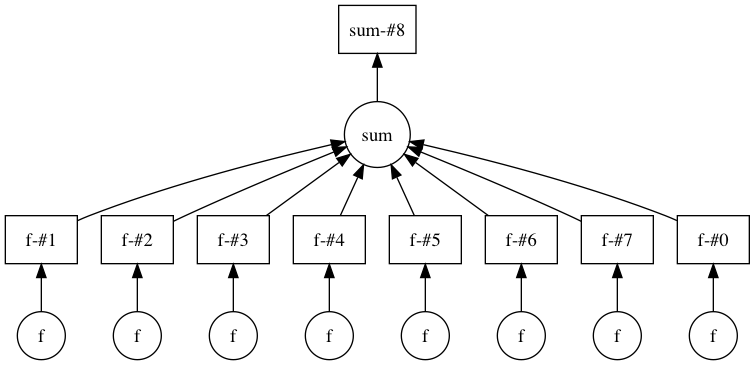

In [60]:
result.visualize()

# sharedmem

http://rainwoodman.github.io/sharedmem/

In [28]:
import sharedmem
counter = sharedmem.empty(1)
counter[:] = 0
with sharedmem.MapReduce() as pool:
    def work(i):
         with pool.critical:
             counter[:] += i
    pool.map(work, range(10))
print(counter)

[ 45.]


In [29]:
import numpy as np
input = np.arange(1024 * 1024 * 128, dtype='f8')
output = sharedmem.empty(1024 * 1024 * 128, dtype='f8')
with sharedmem.MapReduce() as pool:
    chunksize = 1024 * 1024
    def work(i):
        s = slice (i, i + chunksize)
        output[s] = input[s]
        return i, np.sum(input[s])
    def reduce(i, r):
        print('chunk', i, 'done')
        return r
    r = pool.map(work, range(0, len(input), chunksize), reduce=reduce)
print (np.sum(r))



chunk 0 done
chunk 1048576 done
chunk 2097152 done
chunk 3145728 done
chunk 4194304 done
chunk 5242880 done
chunk 6291456 done
chunk 7340032 done
chunk 8388608 done
chunk 9437184 done
chunk 10485760 done
chunk 11534336 done
chunk 12582912 done
chunk 13631488 done
chunk 14680064 done
chunk 15728640 done
chunk 16777216 done
chunk 17825792 done
chunk 18874368 done
chunk 19922944 done
chunk 20971520 done
chunk 22020096 done
chunk 23068672 done
chunk 24117248 done
chunk 25165824 done
chunk 26214400 done
chunk 27262976 done
chunk 28311552 done
chunk 29360128 done
chunk 30408704 done
chunk 31457280 done
chunk 32505856 done
chunk 33554432 done
chunk 34603008 done
chunk 35651584 done
chunk 36700160 done
chunk 37748736 done
chunk 38797312 done
chunk 39845888 done
chunk 40894464 done
chunk 41943040 done
chunk 42991616 done
chunk 44040192 done
chunk 45088768 done
chunk 47185920 done
chunk 46137344 done
chunk 48234496 done
chunk 49283072 done
chunk 50331648 done
chunk 52428800 done
chunk 51380224 d